In [62]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# **Image Captioning**

**CNNs + RNNs (LSTMs)**
- To perform Image Captioning we will require two deep learning models combined into one for the training purpose
- CNNs extract the features from the image of some vector size aka the vector embeddings. The size of these embeddings depend on the type of pretrained network being used for the feature extraction
- LSTMs are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word

<img src="https://miro.medium.com/max/1400/1*6BFOIdSHlk24Z3DFEakvnQ.png">

In [63]:
image_path = '../input/flickr8k/Images'

In [64]:
data = pd.read_csv("../input/flickr8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [65]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

# **Visualization**
- Images and their corresponding captions

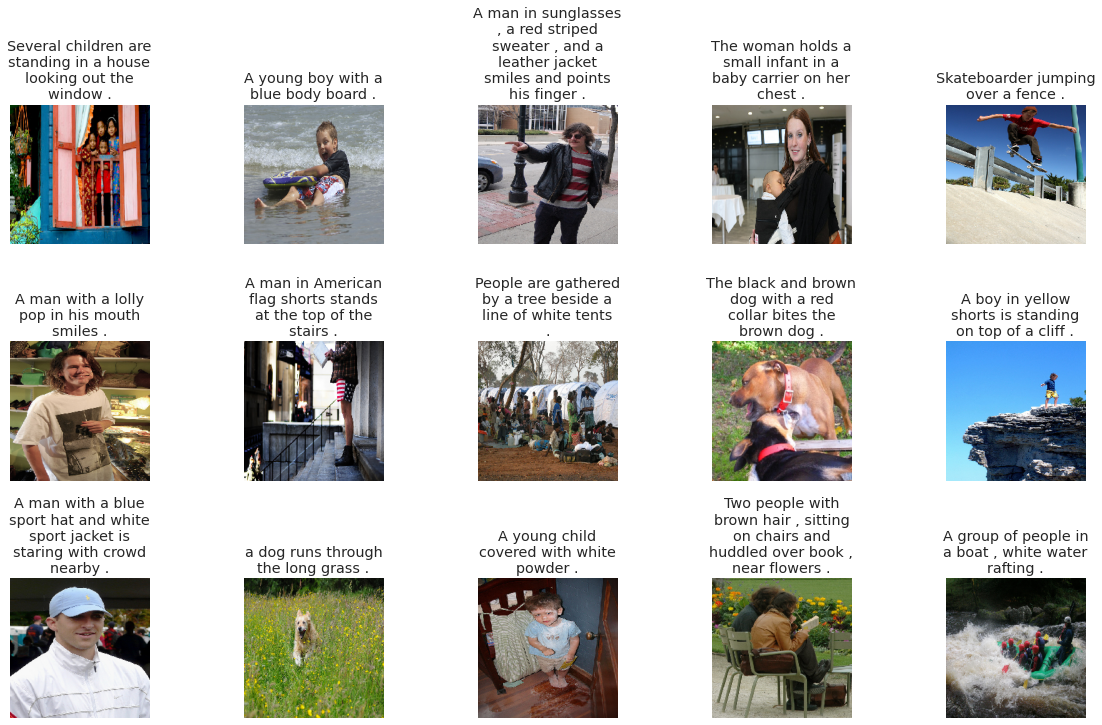

In [66]:
display_images(data.sample(15))

# **1. Caption Text Preprocessing Steps**
- Convert sentences into lowercase
- Remove special characters and numbers present in the text
- Remove extra spaces
- Remove single characters
- Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

In [67]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

## __Preprocessed Text__

In [68]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## __Tokenization and Encoded Representation__
- The words in a sentence are separated/tokenized and encoded in a one hot representation
- These encodings are then passed to the embeddings layer to generate word embeddings

<img src='https://lena-voita.github.io/resources/lectures/word_emb/lookup_table.gif'>

In [69]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.80*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

# **2. Image Feature Extraction**
- DenseNet 201 Architecture is used to extract the features from the images
- Any other pretrained architecture can also be used for extracting features from these images
- Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920

<img src="https://imgur.com/wWHWbQt.jpg">

In [70]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 8091/8091 [10:40<00:00, 12.63it/s]


# **3. Data Generation**
- Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
- The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
- The text embeddings are passed word by word for the caption generation during inference time

In [71]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y




# **4. Modelling**
- The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network 
- The LSTM network starts generating words after each input thus forming a sentence at the end

<img src='https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png'>

#  **5. Methods for LSTM networks inside NLP models**
## Here we use 4 models for trying the best results

In [72]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)


##################################

def caption_model(input1,input2,img_features_reshaped):
    sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
    # Define the attention mechanism
    attention = Attention()([img_features_reshaped, sentence_features])

    merged = Concatenate(axis=1)([sentence_features, attention])
    sentence_features = LSTM(256)(merged)
    x = Dropout(0.5)(sentence_features)
    x = add([x, img_features])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(vocab_size, activation='softmax')(x)

    caption_model = Model(inputs=[input1,input2], outputs=output)
    caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

    return  caption_model

def caption_model_2(input1,input2,img_features_reshaped):
    
    img_features_reshaped_lstm = LSTM(256)(img_features_reshaped)
    sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
    sentence_features_lstm = LSTM(256)(sentence_features)

    merged = concatenate([img_features_reshaped_lstm,sentence_features_lstm],axis=1)
    # Reduce the dimensionality from 512 to 256
    merged = Dense(256, activation='relu')(merged)

    x = Dropout(0.5)(merged)
    x = add([x, img_features])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(vocab_size, activation='softmax')(x)

    caption_model = Model(inputs=[input1,input2], outputs=output)
    caption_model.compile(loss='categorical_crossentropy',optimizer='adam')
    return caption_model

def  caption_model_3(input1,input2,img_features_reshaped):
    sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
    merged = concatenate([img_features_reshaped,sentence_features],axis=1)
    sentence_features = LSTM(256)(merged)
    # sentence_features = Bidirectional(LSTM(256, return_sequences=True))(merged)
    x = Dropout(0.5)(sentence_features)
    x = add([x, img_features])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(vocab_size, activation='softmax')(x)

    caption_model = Model(inputs=[input1,input2], outputs=output)
    caption_model.compile(loss='categorical_crossentropy',optimizer='adam')
    return caption_model
    
def  caption_model_4(input1,input2,img_features_reshaped):
    img_features_reshaped_lstm = LSTM(256)(img_features_reshaped)

    #Two diffenrent features
    #Extract features from a discrete sequence of integers (possibly text data)
    #and use an LSTM layer to capture the temporal/sequential information in these features.
    sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
    sentence_features_lstm = LSTM(256)(sentence_features)

    #Use the Attention layer to compute attention weights and outputs
    attention_out = Attention()([img_features_reshaped_lstm, sentence_features_lstm])

    # Concatenate the attention output with the sentence LSTM output
    merged_with_attention = Concatenate(axis=-1)([sentence_features_lstm, attention_out])

    # subsequent layers,reduce the dimensionality from 512 to 256
    x = Dense(256, activation='relu')(merged_with_attention)
    x = Dropout(0.5)(x)
    x = add([x, img_features])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(vocab_size, activation='softmax')(x)

    # Define and compile models
    caption_model = Model(inputs=[input1,input2], outputs=output)
    caption_model.compile(loss='categorical_crossentropy',optimizer='adam')
    return caption_model

def  caption_model_5(input1,input2,img_features_reshaped):
    img_features_reshaped_lstm = LSTM(256)(img_features_reshaped)
    sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
    sentence_features_lstm = LSTM(256)(sentence_features)

    merged = concatenate([img_features_reshaped_lstm, sentence_features_lstm], axis=1)
    # Reduce the dimensionality from 512 to 256
    merged = Dense(256, activation='relu')(merged)

    # Add an LSTM layer after the merged layer
    merged_lstm = LSTM(256, return_sequences=False)(Reshape((1, 256))(merged))

    x = Dropout(0.5)(merged_lstm)
    x = add([x, img_features])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(vocab_size, activation='softmax')(x)

    caption_model = Model(inputs=[input1, input2], outputs=output)
    caption_model.compile(loss='categorical_crossentropy', optimizer='adam')
    return caption_model

In [73]:
from tensorflow.keras.utils import plot_model

## **Model Modification**
- A slight change has been made in the original model architecture to push the performance. The image feature embeddings are added to the output of the LSTMs and then passed on to the fully connected layers
- This slightly improves the performance of the model orignally proposed back in 2014: __Show and Tell: A Neural Image Caption Generator__ (https://arxiv.org/pdf/1411.4555.pdf)

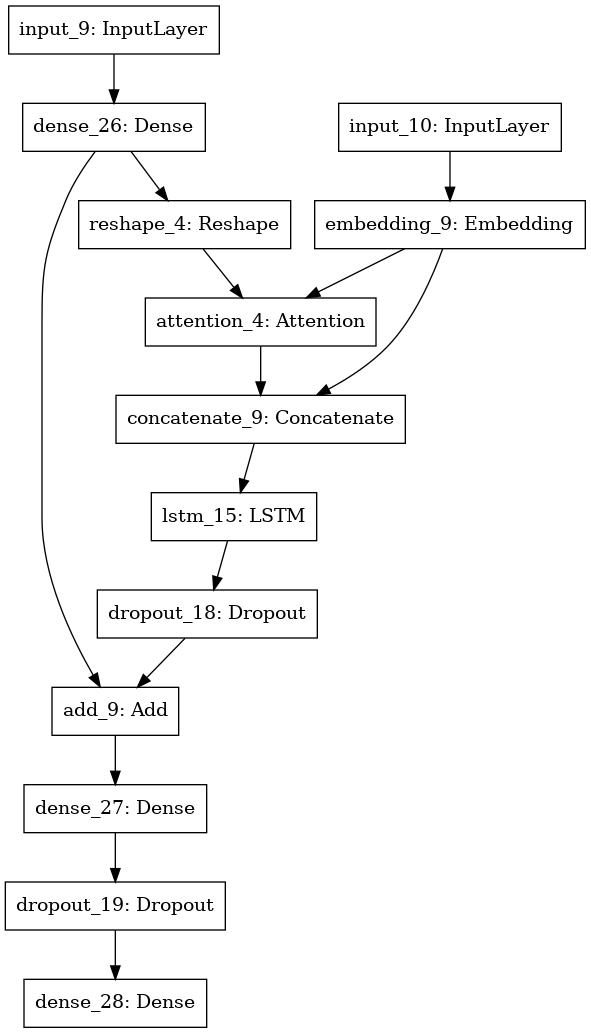

In [74]:
caption_model = caption_model(input1, input2,img_features_reshaped)
plot_model(caption_model)

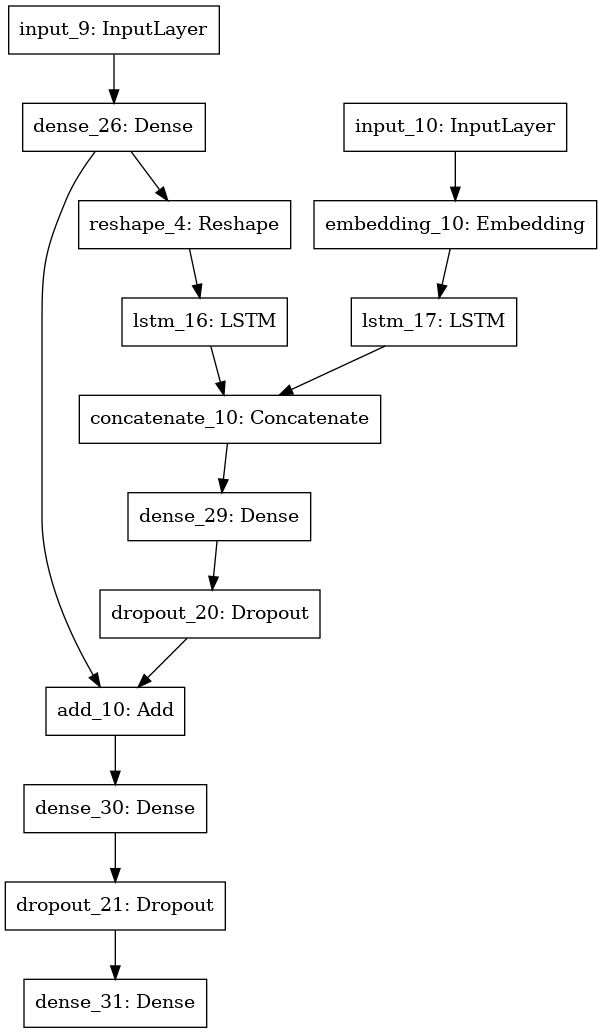

In [75]:
caption_model_2=caption_model_2(input1,input2,img_features_reshaped)
plot_model(caption_model_2)

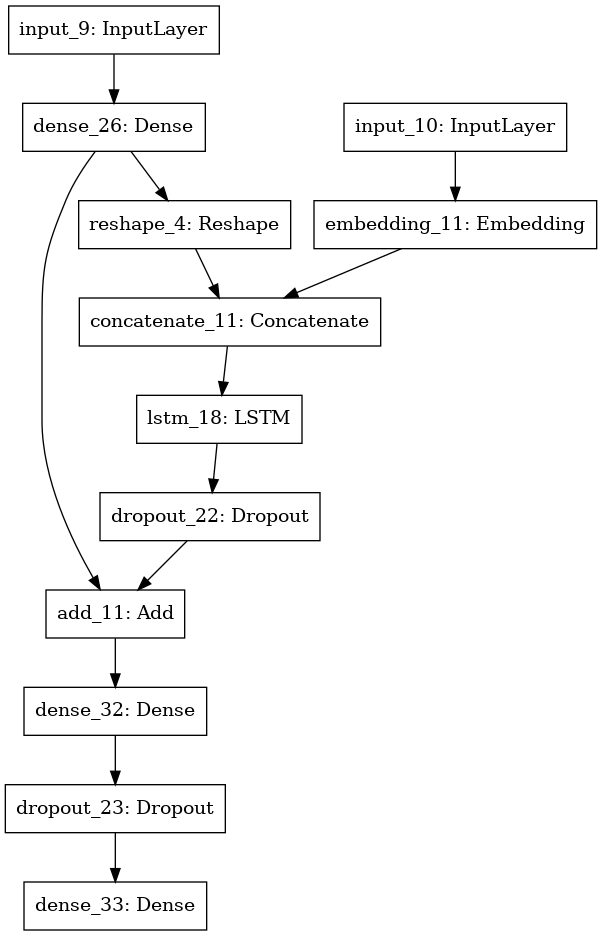

In [76]:
caption_model_3=caption_model_3(input1,input2,img_features_reshaped)
plot_model(caption_model_3)

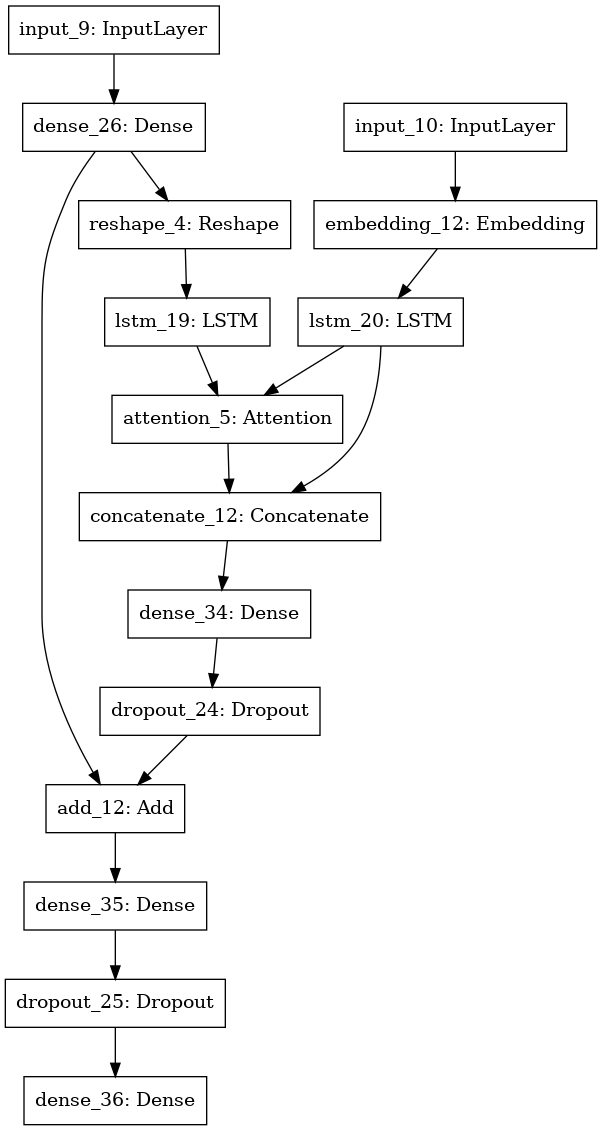

In [77]:
caption_model_4 = caption_model_4(input1,input2,img_features_reshaped)
plot_model(caption_model_4)

# **6. Training our designed models**

In [78]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)



In [79]:
# att->con->LSTM
earlystopping_1 = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)
learning_rate_reduction_1 = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=0.00000001)
checkpoint_1 = ModelCheckpoint("model_1.h5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)

# att->con
earlystopping_2 = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)
learning_rate_reduction_2 = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=0.00000001)
checkpoint_2 = ModelCheckpoint("model_2.h5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)

# con->LSTM
earlystopping_3 = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)
learning_rate_reduction_3 = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=0.00000001)
checkpoint_3 = ModelCheckpoint("model_3.h5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)

# LSTM->att->con
earlystopping_4 = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)
learning_rate_reduction_4 = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=0.00000001)
checkpoint_4 = ModelCheckpoint("model_4.h5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)

In [80]:
history_att_lstm = caption_model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[checkpoint_1, earlystopping_1, learning_rate_reduction_1])

history_lstm_con = caption_model_2.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[checkpoint_2, earlystopping_2, learning_rate_reduction_2])

history_con_lstm = caption_model_3.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[checkpoint_3, earlystopping_3, learning_rate_reduction_3])

history_lstm_att = caption_model_4.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[checkpoint_4, earlystopping_4, learning_rate_reduction_4])

Epoch 1/20
505/505 [==============================] - 226s 444ms/step - loss: 5.2106 - val_loss: 4.3345

Epoch 00001: val_loss improved from inf to 4.33453, saving model to model_1.h5
Epoch 2/20
505/505 [==============================] - 48s 94ms/step - loss: 4.2275 - val_loss: 4.0013

Epoch 00002: val_loss improved from 4.33453 to 4.00127, saving model to model_1.h5
Epoch 3/20
505/505 [==============================] - 47s 93ms/step - loss: 3.9446 - val_loss: 3.8500

Epoch 00003: val_loss improved from 4.00127 to 3.85002, saving model to model_1.h5
Epoch 4/20
505/505 [==============================] - 46s 91ms/step - loss: 3.7642 - val_loss: 3.7609

Epoch 00004: val_loss improved from 3.85002 to 3.76095, saving model to model_1.h5
Epoch 5/20
505/505 [==============================] - 47s 93ms/step - loss: 3.6345 - val_loss: 3.7255

Epoch 00005: val_loss improved from 3.76095 to 3.72552, saving model to model_1.h5
Epoch 6/20
505/505 [==============================] - 47s 92ms/step - lo

## **Learning Curve**
- The model has clearly overfit, possibly due to less amount of data
- We can tackle this problem in two ways
    1. Train the model on a larger dataset Flickr40k
    2. Attention Models

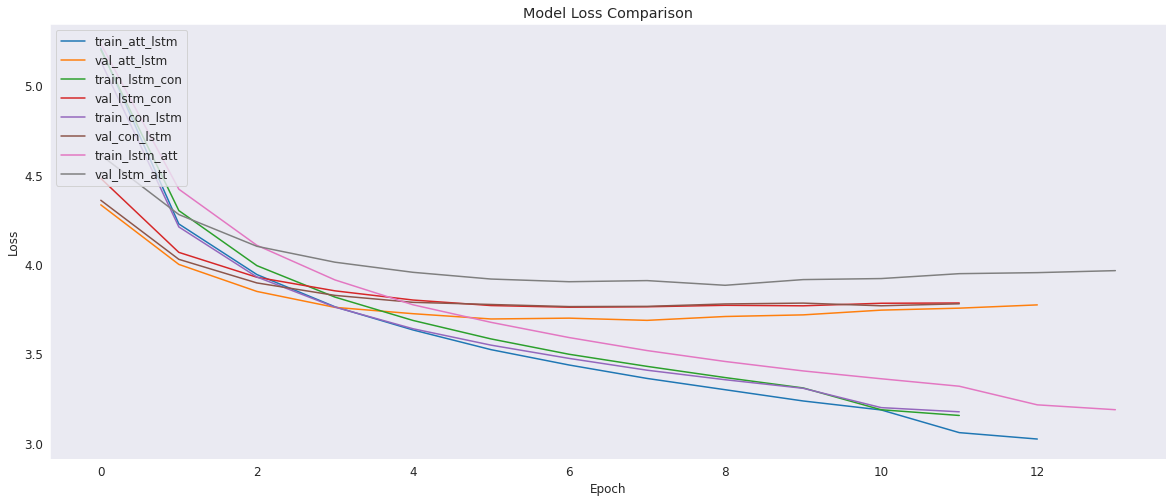

In [87]:
plt.figure(figsize=(20,8))


plt.plot(history_att_lstm.history['loss'], label='train_att_lstm')
plt.plot(history_att_lstm.history['val_loss'], label='val_att_lstm')


plt.plot(history_lstm_con.history['loss'], label='train_lstm_con')
plt.plot(history_lstm_con.history['val_loss'], label='val_lstm_con')


plt.plot(history_con_lstm.history['loss'], label='train_con_lstm')
plt.plot(history_con_lstm.history['val_loss'], label='val_con_lstm')


plt.plot(history_lstm_att.history['loss'], label='train_lstm_att')
plt.plot(history_lstm_att.history['val_loss'], label='val_lstm_att')

plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()


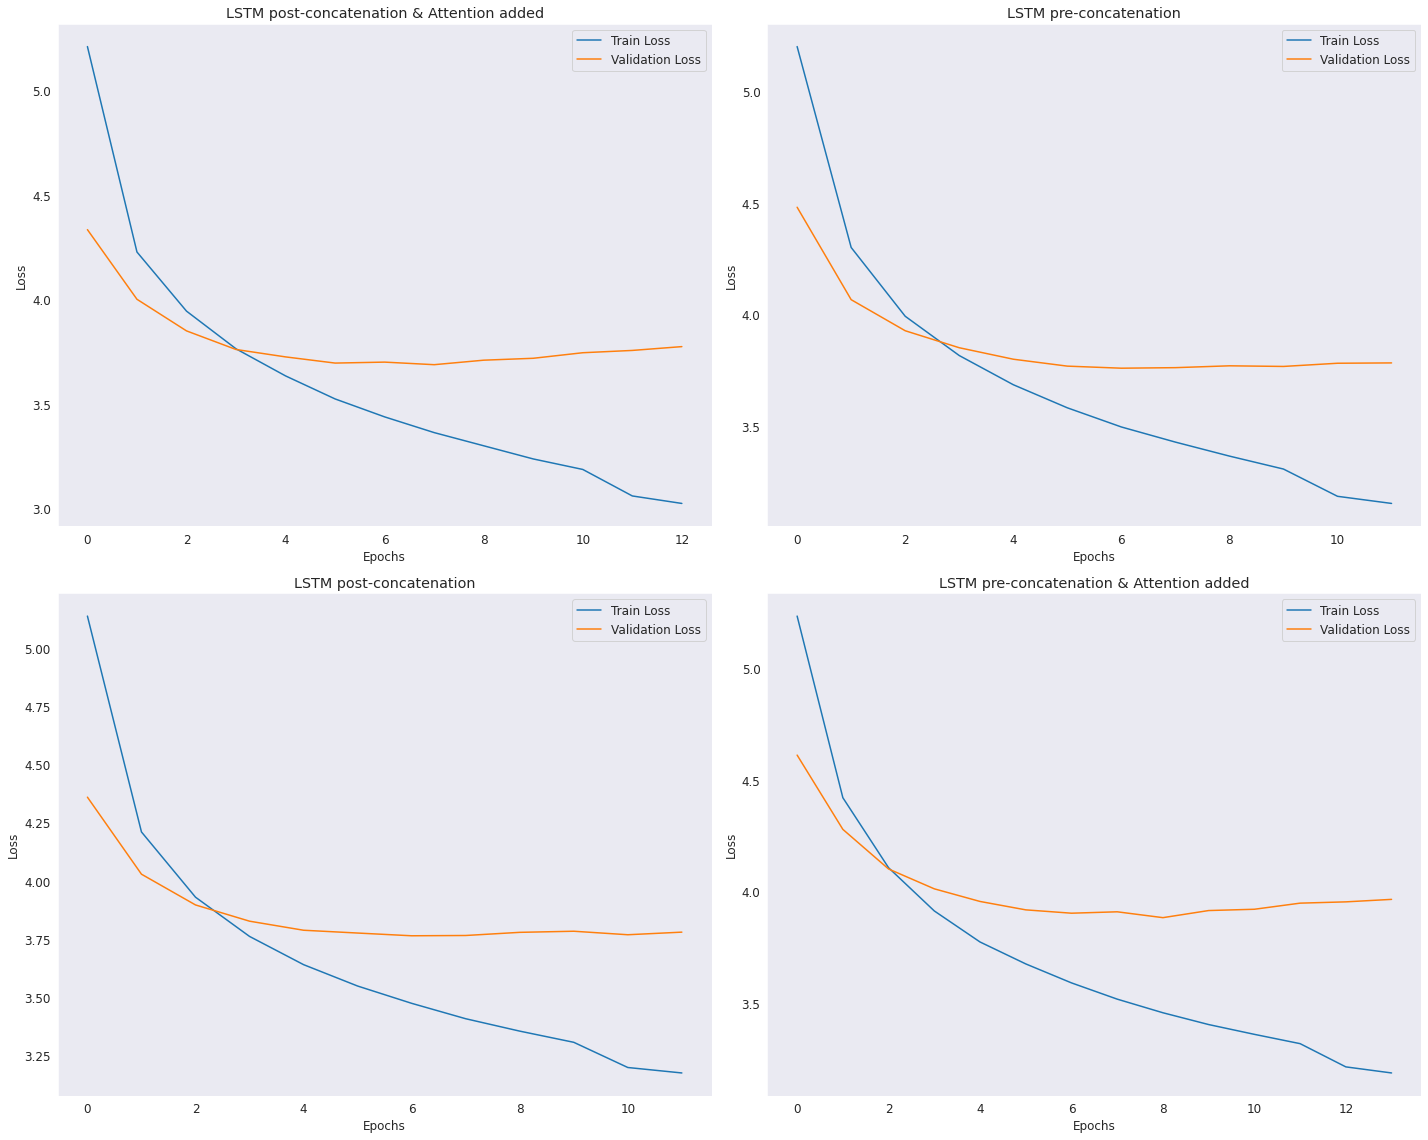

In [88]:
fig, axes = plt.subplots(2, 2, figsize=(20,16))

models = [history_att_lstm, history_lstm_con, history_con_lstm, history_lstm_att]
titles = ['LSTM post-concatenation & Attention added', 'LSTM pre-concatenation', 'LSTM post-concatenation', 'LSTM pre-concatenation & Attention added']

for i, ax in enumerate(axes.flat):
    ax.plot(models[i].history['loss'], label='Train Loss')
    ax.plot(models[i].history['val_loss'], label='Validation Loss')
    ax.set_title(titles[i])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

plt.tight_layout()
plt.show()


## **Caption Generation Utility Functions**
- Utility functions to generate the captions of input images at the inference time.
- Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

In [89]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [90]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

# **7. Results by using models to predict**

## **7.1 Taking 5 Random Samples for Caption Prediction**

  0%|          | 0/3 [00:00<?, ?it/s]

-----------------------------------
Official Answer: startseq man jumps in the air while sky surfing endseq
LSTM post-concatenation & Attention added startseq man is riding bike on the water endseq BLEU Score: 0.4344
LSTM pre-concatenation startseq man in blue shirt is jumping off the water endseq BLEU Score: 0.4617
LSTM post-concatenation startseq man is riding on the air endseq BLEU Score: 0.5063
LSTM pre-concatenation & Attention added startseq man is doing jump in the air endseq BLEU Score: 0.3890


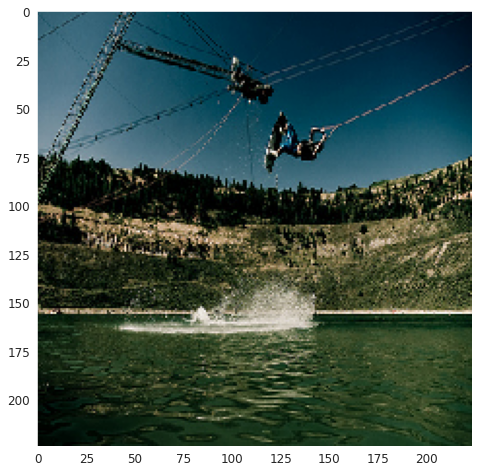

 33%|███▎      | 1/3 [00:01<00:03,  1.73s/it]

-----------------------------------
Official Answer: startseq woman wearing hat leans over to man who has tattoo endseq
LSTM post-concatenation & Attention added startseq man in red shirt is holding his hand endseq BLEU Score: 0.6059
LSTM pre-concatenation startseq man in black shirt is in the air endseq BLEU Score: 0.6059
LSTM post-concatenation startseq man in black shirt is wearing red shirt endseq BLEU Score: 0.6511
LSTM pre-concatenation & Attention added startseq man is wearing red shirt and hat in the background endseq BLEU Score: 0.8034


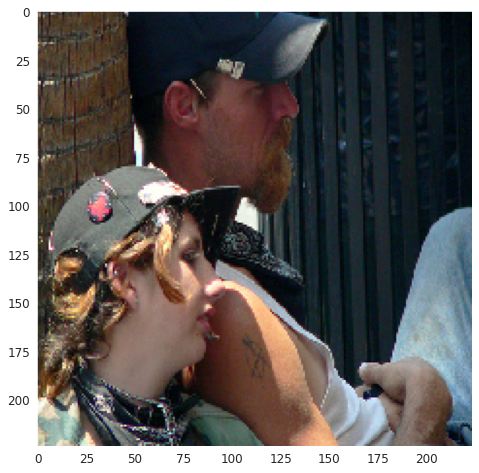

 67%|██████▋   | 2/3 [00:03<00:01,  1.93s/it]

-----------------------------------
Official Answer: startseq soccer player tackles player from the other team endseq
LSTM post-concatenation & Attention added startseq the basketball player is playing basketball endseq BLEU Score: 0.6549
LSTM pre-concatenation startseq two men are playing ball in the air endseq BLEU Score: 0.7401
LSTM post-concatenation startseq football player in red uniform is playing in the field endseq BLEU Score: 0.7598
LSTM pre-concatenation & Attention added startseq two men are playing in the air in the air endseq BLEU Score: 0.7071


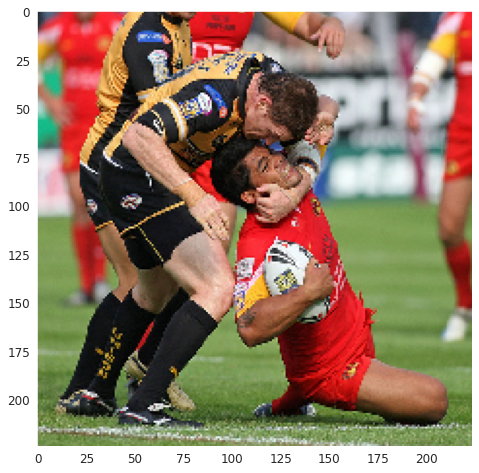

100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


In [108]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

RED = '\033[91m'
GREEN = '\033[92m'
BLUE = '\033[94m'
ENDC = '\033[0m'

samples = test.sample(3)
samples.reset_index(drop=True,inplace=True)

rankings = {"LSTM post-concatenation & Attention added": [],
            "LSTM pre-concatenation": [],
            "LSTM post-concatenation": [],
            "LSTM pre-concatenation & Attention added": []}

for index, record in tqdm(samples.iterrows(), total=samples.shape[0]):
    fig, ax = plt.subplots(figsize=(10, 8))
    img = load_img(os.path.join(image_path, record['image']), target_size=(224, 224))
    ax.imshow(img)
    print("-----------------------------------")

    # Official answer
    reference = samples.loc[index,'caption'].split()
    print(f"Official Answer: {samples.loc[index,'caption']}")
    
    # Predictions and BLEU scores
    captions_scores = {}
    models = ["LSTM post-concatenation & Attention added", 
              "LSTM pre-concatenation", 
              "LSTM post-concatenation", 
              "LSTM pre-concatenation & Attention added"]
    models_functions = [caption_model, caption_model_2, caption_model_3, caption_model_4]
    
    for model_name, model_function in zip(models, models_functions):
        caption = predict_caption(model_function, record['image'], tokenizer, max_length, features).split()
        score = sentence_bleu([reference], caption)
        captions_scores[model_name] = score
        print(RED + model_name + ENDC, " ".join(caption), f"BLEU Score: {score:.4f}")

    # Rank models for current image
    sorted_scores = sorted(captions_scores.items(), key=lambda x: x[1], reverse=True)
    for rank, (model, _) in enumerate(sorted_scores, 1):
        rankings[model].append(rank)

    plt.show()

## 7.2 Count the ranking for BLEU of our seleted models prediction results

100%|██████████| 200/200 [05:12<00:00,  1.56s/it]



Average Ranking:
1. LSTM post-concatenation & Attention added: 2.14
2. LSTM pre-concatenation: 2.45
3. LSTM post-concatenation: 2.52
4. LSTM pre-concatenation & Attention added: 2.88


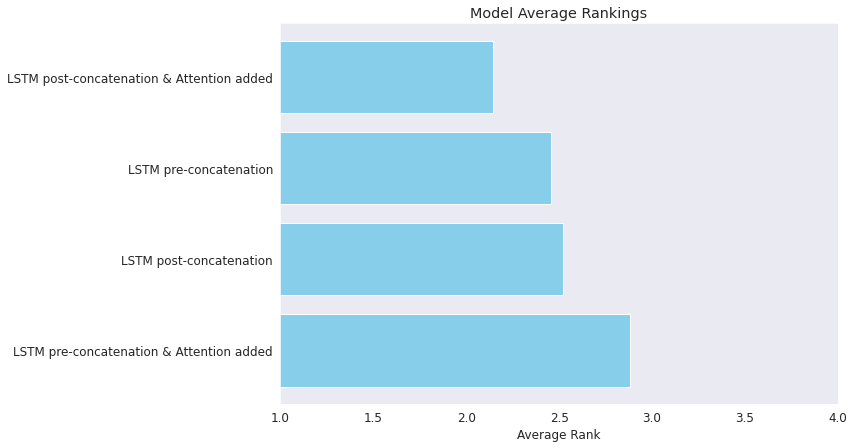

In [110]:
samples = test.sample(200)
samples.reset_index(drop=True,inplace=True)
for index, record in tqdm(samples.iterrows(), total=samples.shape[0]):
    # Official answer
    reference = samples.loc[index,'caption'].split()
    
    # Predictions and BLEU scores
    captions_scores = {}
    models = ["LSTM post-concatenation & Attention added", 
              "LSTM pre-concatenation", 
              "LSTM post-concatenation", 
              "LSTM pre-concatenation & Attention added"]
    models_functions = [caption_model, caption_model_2, caption_model_3, caption_model_4]
    
    for model_name, model_function in zip(models, models_functions):
        caption = predict_caption(model_function, record['image'], tokenizer, max_length, features).split()
        score = sentence_bleu([reference], caption)
        captions_scores[model_name] = score

    # Rank models for current image
    sorted_scores = sorted(captions_scores.items(), key=lambda x: x[1], reverse=True)
    for rank, (model, _) in enumerate(sorted_scores, 1):
        rankings[model].append(rank)

# Average Ranking
print("\nAverage Ranking:")
average_rankings = {model: sum(ranks)/len(ranks) for model, ranks in rankings.items()}
sorted_avg_rankings = sorted(average_rankings.items(), key=lambda x: x[1])
for idx, (model, rank) in enumerate(sorted_avg_rankings, 1):
    print(f"{idx}. {model}: {rank:.2f}")
    

models = list(average_rankings.keys())
avg_ranks = list(average_rankings.values())

sorted_indices = sorted(range(len(avg_ranks)), key=lambda k: avg_ranks[k])
models = [models[i] for i in sorted_indices]
avg_ranks = [avg_ranks[i] for i in sorted_indices]

plt.figure(figsize=(10, 7))
plt.barh(models, avg_ranks, color='skyblue')
plt.xlabel('Average Rank')
plt.title('Model Average Rankings')
plt.xlim(1, len(models))  
plt.gca().invert_yaxis()

plt.show()

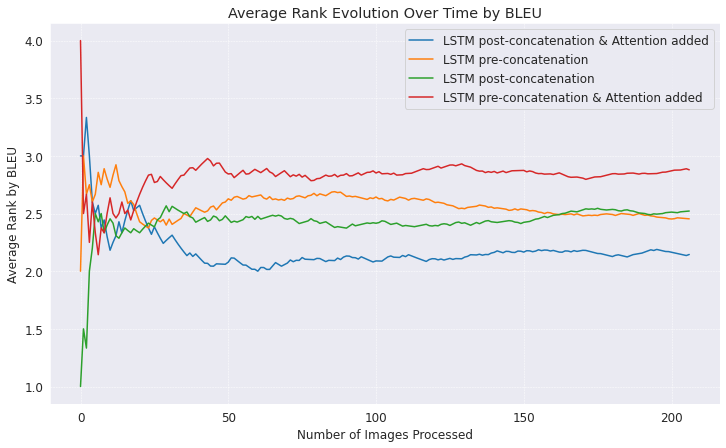

In [111]:
cumulative_rankings = {model: np.cumsum(ranks) for model, ranks in rankings.items()}

plt.figure(figsize=(12, 7))

for model, cum_ranks in cumulative_rankings.items():
    avg_ranks_over_time = cum_ranks / (np.arange(len(cum_ranks)) + 1)
    plt.plot(avg_ranks_over_time, label=model)

plt.xlabel('Number of Images Processed')
plt.ylabel('Average Rank by BLEU')
plt.title('Average Rank Evolution Over Time by BLEU')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()